/Users/ayushmaandhanai/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
[*********************100%***********************]  2 of 2 completed


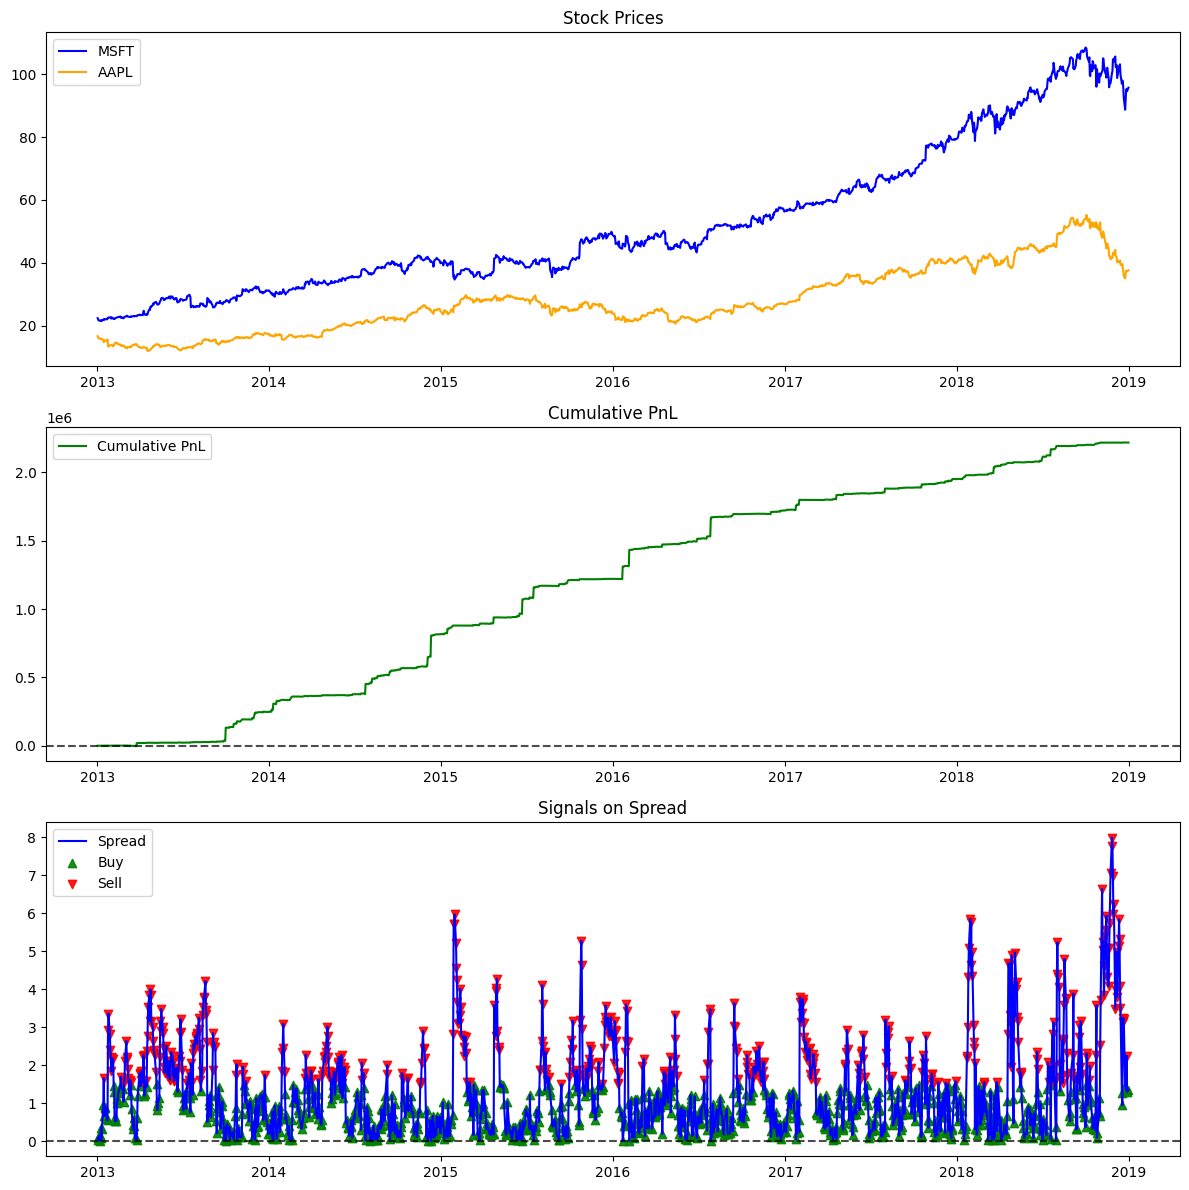

Final Cumulative PnL: 2217796.50


In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pykalman import KalmanFilter


def compute_kalman_regression(asset1_prices, asset2_prices):
    delta = 1e-5
    transition_covariance = delta / (1 - delta) * np.eye(2)
    observation_matrix = np.vstack([np.asarray(asset1_prices), np.ones(len(asset1_prices))]).T[:, np.newaxis]
    kalman = KalmanFilter(
        n_dim_obs=1,
        n_dim_state=2,
        initial_state_mean=np.zeros(2),
        initial_state_covariance=np.ones((2, 2)),
        transition_matrices=np.eye(2),
        observation_matrices=observation_matrix,
        observation_covariance=1.0,
        transition_covariance=transition_covariance,
    )
    return kalman.filter(np.asarray(asset2_prices))[0]


def compute_spread(asset1_price, asset2_price):
    state_means = compute_kalman_regression(asset2_price, asset1_price)
    return pd.Series(abs(asset1_price - state_means[:, 0] * asset2_price - state_means[:, 1]), index=asset1_price.index)


def check_stop_loss(spread_series, stop_threshold):
    return spread_series > stop_threshold


def calculate_position_size(spread_series, risk_parameter):
    return (risk_parameter / spread_series.rolling(window=30).std()).fillna(0)


def check_volatility(spread_series, vol_threshold):
    return spread_series.rolling(window=30).std() > vol_threshold


def run_backtest(market_data, asset1, asset2, stop_loss_threshold=2, risk_factor=0.1, vol_threshold=0.02):
    spread_series = compute_spread(market_data[asset1], market_data[asset2])
    buy_signal = spread_series < 1.5
    sell_signal = spread_series > 1.5
    stop_loss = check_stop_loss(spread_series, stop_loss_threshold)
    volatility = check_volatility(spread_series, vol_threshold)
    position_size = calculate_position_size(spread_series, risk_factor) * 10000
    returns = spread_series.pct_change().shift(-1).fillna(0)
    positions = np.zeros(len(spread_series))
    positions[buy_signal] = 1
    positions[sell_signal] = -1
    positions[stop_loss] = 0
    positions[volatility] = position_size[volatility]
    daily_pnl = positions * returns
    cumulative_pnl = daily_pnl.cumsum()
    plt.figure(figsize=(12, 12))
    plt.subplot(3, 1, 1)
    plt.plot(market_data[asset1], label=asset1, color="blue")
    plt.plot(market_data[asset2], label=asset2, color="orange")
    plt.title("Stock Prices")
    plt.legend()
    plt.subplot(3, 1, 2)
    plt.plot(cumulative_pnl, label="Cumulative PnL", color="green")
    plt.axhline(0, color="black", linestyle="--", alpha=0.7)
    plt.title("Cumulative PnL")
    plt.legend()
    plt.subplot(3, 1, 3)
    plt.plot(spread_series.index, spread_series, label="Spread", color="blue")
    plt.scatter(spread_series.index[buy_signal], spread_series[buy_signal], marker="^", color="green", alpha=0.9, label="Buy")
    plt.scatter(spread_series.index[sell_signal], spread_series[sell_signal], marker="v", color="red", alpha=0.9, label="Sell")
    plt.axhline(0, color="black", linestyle="--", alpha=0.7)
    plt.title("Signals on Spread")
    plt.legend()
    plt.tight_layout()
    plt.savefig("results.png")
    plt.show()
    return cumulative_pnl, daily_pnl


stock_symbols = ["MSFT", "AAPL"]
start_date, end_date = "2013-01-01", "2019-01-01"
market_data = yf.download(stock_symbols, start=start_date, end=end_date)["Close"]
cumulative_pnl, daily_pnl = run_backtest(market_data, "MSFT", "AAPL", stop_loss_threshold=2, risk_factor=0.1, vol_threshold=0.02)
print(f"Final Cumulative PnL: {cumulative_pnl.iloc[-1]:.2f}")